# Chicago Traffic Incidents Involving Cyclists/Pedestrians in Last 12 Months
### Prepared by: Michael Goodman
>### Data Source: Chicago Data Portal
>#### API Documentation: https://dev.socrata.com/foundry/data.cityofchicago.org/{API_ROOT}
>>#### Use the appropriate root from the variables in the documentation URL.
>>#### ie. for the documentation of the crash API. You would go to https://dev.socrata.com/foundry/data.cityofchicago.org/85ca-t3if

### Libraries to Import

In [378]:
#Imports
#use pip to install any needed libraries below
import pandas as pd
import requests
import json
import time
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
from sodapy import Socrata
from cdp_secrets import *
print('completed at ' + str(datetime.now()))

completed at 2023-01-05 20:56:54.399284


### Chicago Data Portal Connection

In [379]:
#Constants
chicago_url="data.cityofchicago.org"
vehicle_api_root="68nd-jvt3"
people_api_root="u6pd-qa9d"
crash_api_root="85ca-t3if"
district_root="z8bn-74gv"
beat_root="n9it-hstw"

#Chicago Data Portal Connection
cdp = Socrata(chicago_url,
                 token,
                 username,
                 password)
print('completed at ' + str(datetime.now()))

completed at 2023-01-05 20:56:58.586951


### Function to call API and format to DataFrame

In [380]:
def callAPI(root: str, filter: str) -> pd.DataFrame:
    results=cdp.get(root, query=filter)
    df=pd.DataFrame.from_records(results)
    return df
print('completed at ' + str(datetime.now()))

completed at 2023-01-05 20:57:02.064308


### Create string variables for today and one year ago

In [381]:
#Get dates for the last 12 months
today = datetime.now().strftime("%Y-%m-%d")

year_ago = (datetime.now() - relativedelta(years=1)).strftime("%Y-%m-%d")
print(today)
print(year_ago)
print('completed at ' + str(datetime.now()))

2023-01-05
2022-01-05
completed at 2023-01-05 20:57:04.324759


### Queries for API Calls. Filters based on project specification

In [404]:
#limit required for SoQL query, as we are filtering for one year limit is set high to capture all records
limit='1000000000'

#Filters use SQL structure, some where clauses use a different format. Refer to API Documentation for correct syntax
vehicle_filter= """Select crash_record_id,crash_date,make,model,vehicle_type 
                    where vehicle_type is not null and crash_date between '%s' and '%s'
                    limit %s"""%(year_ago,today,limit) 

people_filter= """Select person_id,crash_record_id,crash_date,person_type,age,sex,
                injury_classification,pedpedal_action,pedpedal_visibility,pedpedal_location
                Where CRASH_DATE between '%s' and '%s' and
                (person_type='PEDESTRIAN' or person_type='BICYCLE') limit %s"""% (year_ago,today,limit)

crash_filter="""Select crash_record_id,crash_date,beat_of_occurrence as beat_num,crash_month,crash_day_of_week,location
                where crash_date between '%s' and '%s' limit %s"""% (year_ago,today,limit)

district_filter="""Select distinct district,district_name limit 1000"""

beat_filter="""Select beat_num,district limit 300"""

print('completed at ' + str(datetime.now()))

completed at 2023-01-05 21:19:20.058851


### Create DataFrames from API Results

In [383]:
#People Table
people_df=callAPI(people_api_root,people_filter)

print('completed at ' + str(datetime.now()))

completed at 2023-01-05 20:57:11.596833


In [384]:
#Vehicle Table
vehicle_df=callAPI(vehicle_api_root,vehicle_filter)

print('completed at ' + str(datetime.now()))

completed at 2023-01-05 20:57:19.540316


In [406]:
#Crash Table
crash_df=callAPI(crash_api_root,crash_filter)

print('completed at ' + str(datetime.now()))

completed at 2023-01-05 21:19:58.003449


In [415]:
#Beat To District Key Table

#Police Beat
beat_df=callAPI(beat_root,beat_filter)

#Remove leading 0 from district field
beat_df['district']=pd.to_numeric(beat_df['district'])
beat_df['district']=beat_df['district'].apply(lambda x: str(x))

#Remove leading 0 from beat_num field
beat_df['beat_num']=pd.to_numeric(beat_df['beat_num'])
beat_df['beat_num']=beat_df['beat_num'].apply(lambda x: str(x))

#District table
district_df=callAPI(district_root,district_filter)

#join together to create matching table
district_key=pd.merge(beat_df,district_df,on='district',how='left')

print(district_key)
print('completed at ' + str(datetime.now()))

    beat_num district   district_name
0       1713       17     Albany Park
1       3100       31             NaN
2       1651       16  Jefferson Park
3       1914       19       Town Hall
4       1915       19       Town Hall
..       ...      ...             ...
272      314        3  Grand Crossing
273      825        8    Chicago Lawn
274      313        3  Grand Crossing
275      823        8    Chicago Lawn
276      312        3  Grand Crossing

[277 rows x 3 columns]
completed at 2023-01-05 21:28:30.851114


### Join DataFrames to create project Data Model

In [416]:
#Join People and Vehicle data sets on crash_record_id
people_vehicle=pd.merge(people_df,vehicle_df[['crash_record_id','make','model','vehicle_type']], on='crash_record_id', how='left')
#print(people_vehicle)
print('completed at ' + str(datetime.now()))

completed at 2023-01-05 21:28:38.212126


In [417]:
#Join prior dataset with crash information
crash_pv=pd.merge(people_vehicle,crash_df, on='crash_record_id', how='left')
#print(crash_pv)
print('completed at ' + str(datetime.now()))

completed at 2023-01-05 21:28:40.032027


In [451]:
#Join prior dataset with district ID and Name
merge_df=pd.merge(crash_pv,district_key, on='beat_num', how='left')
#Declare final data model
model=merge_df
#print(model)
print("Model Field List")

n=1
for fields in model.columns:
    print(str(n)+'.'+fields)
    n+=1

print('completed at ' + str(datetime.now()))

Model Field List
1.person_id
2.crash_record_id
3.crash_date_x
4.person_type
5.age
6.sex
7.injury_classification
8.pedpedal_action
9.pedpedal_visibility
10.pedpedal_location
11.make
12.model
13.vehicle_type
14.crash_date_y
15.beat_num
16.crash_month
17.crash_day_of_week
18.location
19.district
20.district_name
completed at 2023-01-05 22:42:02.106522


### Print to Excel
#### Excel ending in "pbi" can be imported to business intelligence tool like PowerBI or Tableau for further in-depth analysis. Running this notebook and then refreshing Tableau/PowerBI will ensure the latest data is imported

In [446]:
model.to_excel('traffic_study_model_'+today+'.xlsx',index=True)
model.to_excel('traffic_study_model_pbi.xlsx',index=True)
print('completed at '+str(datetime.now()))

completed at 2023-01-05 22:30:35.196377


# Analysis

>### Severity of Incidents to Pedestrians and Cyclists

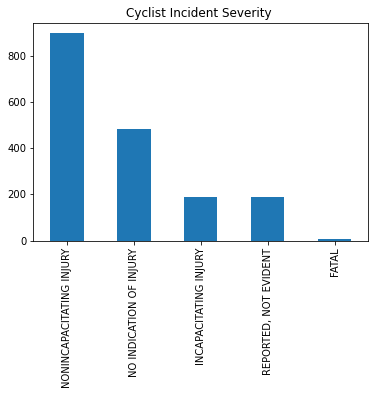

[897 484 188 187   7]


In [494]:
#Cyclist Severity plot
temp_df=model[model['person_type']=='BICYCLE']
temp_df = temp_df['injury_classification'].value_counts().head(5)
temp_df.plot(kind='bar', y='person_id')
plt.title('Cyclist Incident Severity ')
plt.show()

print(temp_df.values)

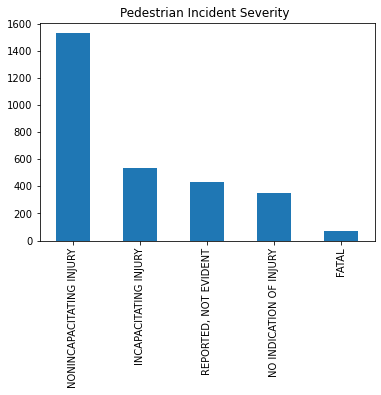

[1527  538  429  349   69]


In [495]:
#Pedestrian Severity Plot
temp_df=model[model['person_type']=='PEDESTRIAN']
temp_df = temp_df['injury_classification'].value_counts().head(5)
temp_df.plot(kind='bar', y='person_id')
plt.title('Pedestrian Incident Severity ')
plt.show()
print(temp_df.values)

>### Comparison of incident count between Male and Female

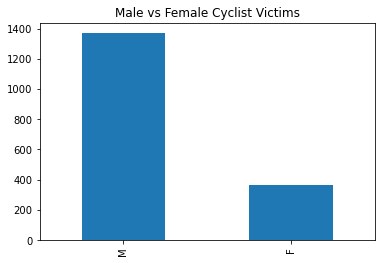

[1370  364]


In [496]:
temp_df=model[model['person_type']=='BICYCLE']

#temp_df=temp_df.groupby('sex').count()
temp_df = temp_df['sex'].value_counts().head(2)
temp_df.plot(kind='bar', y='person_id')
plt.title('Male vs Female Cyclist Victims')
plt.show()
print(temp_df.values)

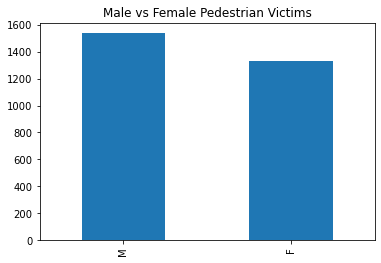

[1538 1327]


In [497]:
temp_df=model[model['person_type']=='PEDESTRIAN']
#temp_df=temp_df.groupby('sex').count()
temp_df = temp_df['sex'].value_counts().head(2)
temp_df.plot(kind='bar', y='person_id')
plt.title('Male vs Female Pedestrian Victims')
plt.show()
print(temp_df.values)

>### Incidents by District

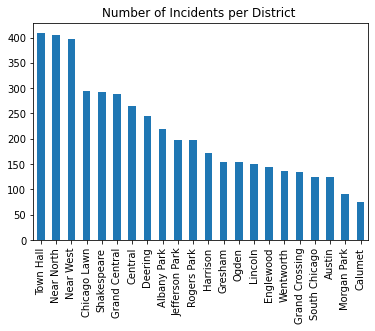

[409 405 398 295 293 289 264 245 220 198 197 172 155 154 151 145 136 135
 125 124  90  76]


In [498]:
#Incidents by district
temp_df = model['district_name'].value_counts().head(25)
temp_df.plot(kind='bar', y='person_id')
plt.title('Number of Incidents per District ')
plt.show()
print(temp_df.values)

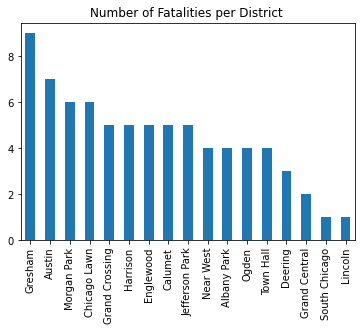

[9 7 6 6 5 5 5 5 5 4 4 4 4 3 2 1 1]


In [499]:
#Fatal incidents by district
temp_df=model[model['injury_classification']=='FATAL']
temp_df = temp_df['district_name'].value_counts().head(25)
temp_df.plot(kind='bar', y='person_id')
plt.title('Number of Fatalities per District ')
plt.show()
print(temp_df.values)

>### Incidents by Vehicle Type

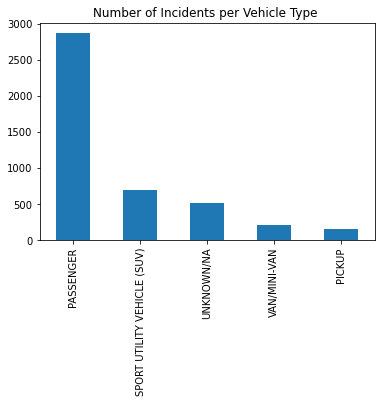

[2867  700  522  208  161]


In [500]:
#Incidents by type of car
temp_df = model['vehicle_type'].value_counts().head(5)
temp_df.plot(kind='bar', y='person_id')
plt.title('Number of Incidents per Vehicle Type ')
plt.show()
print(temp_df.values)

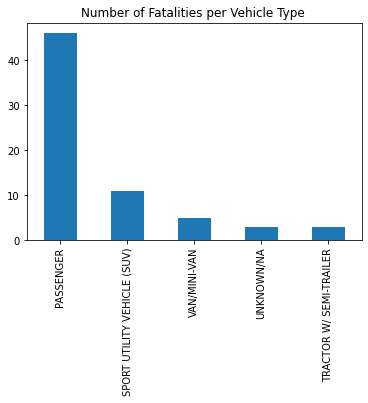

[46 11  5  3  3]


In [501]:
#Fatal incidents by type of car
temp_df=model[model['injury_classification']=='FATAL']
temp_df = temp_df['vehicle_type'].value_counts().head(5)
temp_df.plot(kind='bar', y='person_id')
plt.title('Number of Fatalities per Vehicle Type ')
plt.show()
print(temp_df.values)